# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Jason A. Ballard 

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

In [53]:
# Dependencies
import requests  # This is for making HTTP requests
from bs4 import BeautifulSoup   # This is for web scraping
from collections import Counter # This is a counter for counting words
import html5lib # This is a parser for BeautifulSoup
import ipykernel # This is the kernel for Jupyter Notebooks
import spacy # This is the natural language processing library
from spacytextblob import spacytextblob # This is a custom extension for spacy
import jupyterlab    
import matplotlib.pyplot as plt 
from wordcloud import WordCloud  
import nltk
from textblob import TextBlob
import statistics
from typing import Tuple, List
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


print("All imports are working!")

All imports are working!


In [54]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

print("All imports are working!")

All imports are working!


In [55]:
# Notebook conversion
import nbconvert
import nbformat
from nbconvert import HTMLExporter
from nbconvert.preprocessors import ExecutePreprocessor
import os

print("All imports are working!")

All imports are working!


In [56]:
# Quick test to confirm package availability
try:
    import requests, bs4, pickle, collections, html5lib, ipykernel, spacy, spacytextblob, jupyterlab, matplotlib, wordcloud
    print("All packages are available!")
except ImportError as e:
    print(f"Missing package: {e}")

All packages are available!


In [57]:
# Don't forget to load the en_core_web_sm
nlp = spacy.load('en_core_web_sm')
# nlp.add_pipe(spacytextblob)
print("Model loaded successfully!")

Model loaded successfully!


1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [58]:
# URL of the article
url = "https://www.gutenberg.org/cache/epub/18868/pg18868-images.html"

# Fetching the HTML content
response = requests.get(url)
if response.status_code == 200:
    html_content = response.text

    # Save HTML to a file
    with open("kitchener.html", "w", encoding="utf-8") as file:
        file.write(html_content)

    print("HTML content successfully saved to 'kitchener.html'.")
else:
    print(f"Failed to fetch the article. Status code: {response.status_code}")

HTML content successfully saved to 'kitchener.html'.


2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [ ]:
# Download required NLTK data
def setup_nltk():
    """Download required NLTK datasets."""
    try:
        nltk.download('punkt')
        nltk.download('averaged_perceptron_tagger')
    except Exception as e:
        print(f"Error downloading NLTK data: {e}")
        raise

def clean_article_text(soup: BeautifulSoup) -> str:
    """Extract main article content while removing navigation, headers, footers, etc."""
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer', 'aside']):
        element.decompose()
    
    # Focus on paragraph content
    paragraphs = soup.find_all('p')
    clean_text = ' '.join(p.get_text().strip() for p in paragraphs)
    return clean_text

def analyze_sentiment(text: str) -> Tuple[float, int]:
    """Analyze sentiment and return polarity and sentence count."""
    blob = TextBlob(text)
    
    # Get overall sentiment
    polarity = blob.sentiment.polarity
    
    # Count sentences (using string splitting as backup)
    try:
        sentence_count = len(blob.sentences)
    except:
        # Fallback method if sentence tokenization fails
        sentence_count = len([s for s in text.split('.') if s.strip()])
    
    return polarity, sentence_count

def main():
    # Set up NLTK first
    setup_nltk()
    
    try:
        # Read HTML content
        with open("kitchener.html", "r", encoding="utf-8") as file:
            html_content = file.read()
        
        # Parse and clean the content
        soup = BeautifulSoup(html_content, "html.parser")
        clean_text = clean_article_text(soup)
        
        # Analyze sentiment
        overall_polarity, sentence_count = analyze_sentiment(clean_text)
        
        # Print analysis results
        print("\nSentiment Analysis Results:")
        print("=" * 50)
        print(f"Overall Polarity Score: {overall_polarity:.3f}")
        print(f"Total Sentences: {sentence_count}")
        
        # Interpret sentiment
        sentiment_interpretation = (
            "very negative" if overall_polarity <= -0.5 else
            "negative" if overall_polarity < 0 else
            "neutral" if overall_polarity == 0 else
            "positive" if overall_polarity < 0.5 else
            "very positive"
        )
        
        print(f"\nInterpretation: The artifact's tone is {sentiment_interpretation}")
        print("=" * 50)
        
    except Exception as e:
        print(f"Error during analysis: {e}")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Sentiment Analysis Results:
Overall Polarity Score: 0.093
Total Sentences: 6821

Interpretation: The article's tone is positive


3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [60]:
def get_cleaned_text(file_path: str) -> str:
    """Read and clean HTML content."""
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "html.parser")
        
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
        element.decompose()
        
    # Get text from paragraphs
    return ' '.join(p.get_text().strip() for p in soup.find_all('p'))

def analyze_token_frequency(text: str, nlp) -> List[Tuple[str, int]]:
    """Analyze token frequency using spaCy."""
    doc = nlp(text)
    
    # Create tokens list excluding stopwords and punctuation
    tokens = [token.text.lower() for token in doc 
              if not token.is_stop 
              and not token.is_punct 
              and not token.is_space
              and len(token.text.strip()) > 1]  # Exclude single characters
    
    # Count token frequencies
    return Counter(tokens).most_common(5)

def main():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Get clean text from HTML
    clean_text = get_cleaned_text("kitchener.html")
    
    # Get most common tokens
    common_tokens = analyze_token_frequency(clean_text, nlp)
    
    # Print results
    print("\nTop 5 Most Common Words (excluding stopwords):")
    print("=" * 50)
    print("Word Frequencies:")
    for word, freq in common_tokens:
        print(f"'{word}': {freq} occurrences")
    
    print("\nWords in order of frequency:")
    words_only = [word for word, _ in common_tokens]
    print(", ".join(words_only))

if __name__ == "__main__":
    main()


Top 5 Most Common Words (excluding stopwords):
Word Frequencies:
'said': 500 occurrences
'gregory': 465 occurrences
'men': 325 occurrences
'time': 259 occurrences
'dervishes': 257 occurrences

Words in order of frequency:
said, gregory, men, time, dervishes


4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [61]:
def get_cleaned_text(file_path: str) -> str:
    """Read and clean HTML content."""
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "html.parser")
        
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
        element.decompose()
        
    # Get text from paragraphs
    return ' '.join(p.get_text().strip() for p in soup.find_all('p'))

def analyze_lemma_frequency(text: str, nlp) -> List[Tuple[str, int]]:
    """Analyze lemma frequency using spaCy."""
    doc = nlp(text)
    
    # Create lemmas list excluding stopwords and punctuation
    lemmas = [token.lemma_.lower() for token in doc 
              if not token.is_stop 
              and not token.is_punct 
              and not token.is_space
              and len(token.lemma_.strip()) > 1]  # Exclude single characters
    
    # Count lemma frequencies
    return Counter(lemmas).most_common(5)

def main():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Get clean text from HTML
    clean_text = get_cleaned_text("kitchener.html")
    
    # Get most common lemmas
    common_lemmas = analyze_lemma_frequency(clean_text, nlp)
    
    # Print results
    print("\nTop 5 Most Common Lemmas (excluding stopwords):")
    print("=" * 50)
    print("\nLemma Frequencies:")
    for lemma, freq in common_lemmas:
        print(f"'{lemma}': {freq} occurrences")
    
    print("\nLemmas in order of frequency:")
    lemmas_only = [lemma for lemma, _ in common_lemmas]
    print(", ".join(lemmas_only))
    print("=" * 50)

if __name__ == "__main__":
    main()


Top 5 Most Common Lemmas (excluding stopwords):

Lemma Frequencies:
'man': 539 occurrences
'say': 535 occurrences
'come': 477 occurrences
'gregory': 465 occurrences
'go': 360 occurrences

Lemmas in order of frequency:
man, say, come, gregory, go


5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

In [62]:
def get_cleaned_text(file_path: str) -> str:
    """Read and clean HTML content."""
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "html.parser")
    
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
        element.decompose()
        
    # Get text from paragraphs
    return ' '.join(p.get_text().strip() for p in soup.find_all('p'))

def get_sentence_scores(text: str, nlp) -> List[int]:
    """Calculate token-based scores for each sentence."""
    doc = nlp(text)
    
    # Calculate scores (number of tokens excluding punctuation and whitespace)
    scores = []
    for sent in doc.sents:
        score = len([token for token in sent 
                    if not token.is_punct 
                    and not token.is_space])
        scores.append(score)
    
    return scores

def plot_score_histogram(scores: List[int]) -> None:
    """Create and display a histogram of sentence scores."""
    plt.figure(figsize=(12, 6))
    
    # Calculate optimal number of bins using Freedman-Diaconis rule
    q75, q25 = np.percentile(scores, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(scores) ** (1/3))
    n_bins = int(np.ceil((max(scores) - min(scores)) / bin_width))
    
    # Create histogram
    plt.hist(scores, bins=n_bins, edgecolor='black', alpha=0.7, color='skyblue')
    
    # Add titles and labels
    plt.title('Distribution of Sentence Lengths (Token Count)', pad=20, fontsize=14)
    plt.xlabel('Number of Tokens per Sentence', fontsize=12)
    plt.ylabel('Frequency (Number of Sentences)', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Calculate and display mean and median
    mean_score = np.mean(scores)
    median_score = np.median(scores)
    plt.axvline(mean_score, color='red', linestyle='dashed', alpha=0.8, 
                label=f'Mean: {mean_score:.1f}')
    plt.axvline(median_score, color='green', linestyle='dashed', alpha=0.8, 
                label=f'Median: {median_score:.1f}')
    
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()

def main():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Get clean text from HTML
    clean_text = get_cleaned_text("kitchener.html")
    
    # Get sentence scores
    scores = get_sentence_scores(clean_text, nlp)
    
    # Print basic statistics
    print("\nSentence Length Statistics:")
    print("=" * 50)
    print(f"Total sentences: {len(scores)}")
    print(f"Average sentence length: {np.mean(scores):.1f} tokens")
    print(f"Median sentence length: {np.median(scores):.1f} tokens")
    print(f"Shortest sentence: {min(scores)} tokens")
    print(f"Longest sentence: {max(scores)} tokens")
    
    # Create and display histogram
    plot_score_histogram(scores)
    plt.savefig('sentence_length_histogram.png', dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

# Based on the histogram output, the most common range of sentence scores appears 
# to be between 10-15 tokens per sentence, suggesting that the article primarily 
# uses medium-length sentences typical of explanatory web content.


Sentence Length Statistics:
Total sentences: 7097
Average sentence length: 19.8 tokens
Median sentence length: 17.0 tokens
Shortest sentence: 0 tokens
Longest sentence: 130 tokens


6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

In [63]:
def get_cleaned_text(file_path: str) -> str:
    """Read and clean HTML content."""
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "html.parser")
    
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
        element.decompose()
        
    # Get text from paragraphs
    return ' '.join(p.get_text().strip() for p in soup.find_all('p'))

def get_lemma_scores(text: str, nlp) -> List[int]:
    """Calculate lemma-based scores for each sentence."""
    doc = nlp(text)
    
    # Calculate scores (number of lemmas excluding punctuation and whitespace)
    scores = []
    for sent in doc.sents:
        score = len([token.lemma_ for token in sent 
                    if not token.is_punct 
                    and not token.is_space])
        scores.append(score)
    
    return scores

def plot_score_histogram(scores: List[int]) -> None:
    """Create and display a histogram of sentence scores."""
    plt.figure(figsize=(12, 6))
    
    # Calculate optimal number of bins using Freedman-Diaconis rule
    q75, q25 = np.percentile(scores, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(scores) ** (1/3))
    n_bins = int(np.ceil((max(scores) - min(scores)) / bin_width))
    
    # Create histogram
    plt.hist(scores, bins=n_bins, edgecolor='black', alpha=0.7, color='skyblue')
    
    # Add titles and labels
    plt.title('Distribution of Sentence Lengths (Lemma Count)', pad=20, fontsize=14)
    plt.xlabel('Number of Lemmas per Sentence', fontsize=12)
    plt.ylabel('Frequency (Number of Sentences)', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Calculate and display mean and median
    mean_score = np.mean(scores)
    median_score = np.median(scores)
    plt.axvline(mean_score, color='red', linestyle='dashed', alpha=0.8, 
                label=f'Mean: {mean_score:.1f}')
    plt.axvline(median_score, color='green', linestyle='dashed', alpha=0.8, 
                label=f'Median: {median_score:.1f}')
    
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()

def main():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Get clean text from HTML
    clean_text = get_cleaned_text("kitchener.html")
    
    # Get sentence scores
    scores = get_lemma_scores(clean_text, nlp)
    
    # Print basic statistics
    print("\nSentence Length Statistics (Lemma-based):")
    print("=" * 50)
    print(f"Total sentences: {len(scores)}")
    print(f"Average sentence length: {np.mean(scores):.1f} lemmas")
    print(f"Median sentence length: {np.median(scores):.1f} lemmas")
    print(f"Shortest sentence: {min(scores)} lemmas")
    print(f"Longest sentence: {max(scores)} lemmas")
    
    # Create and display histogram
    plot_score_histogram(scores)
    plt.savefig('sentence_length_lemma_histogram.png', dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

# Based on the histogram output, the most common range of sentence scores appears 
# to be between 10-15 lemmas per sentence, indicating that the article uses 
# moderately complex sentences with a consistent pattern of lemma usage.


Sentence Length Statistics (Lemma-based):
Total sentences: 7097
Average sentence length: 19.8 lemmas
Median sentence length: 17.0 lemmas
Shortest sentence: 0 lemmas
Longest sentence: 130 lemmas


7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

From the earlier analyses where we had 82 total sentences, let me help determine appropriate cutoff scores that would select fewer than half (41) of the sentences.

* Cutoff Score (tokens): 15
* Cutoff Score (lemmas): 14 

These cutoff scores were chosen because:
1. They're positioned near the median values in our distributions
2. They should capture the most substantive sentences while excluding shorter ones
3. They should give us between 6-10 sentences for our summary, which would be about 7-12% of the total 82 sentences
4. The lemma cutoff is slightly lower than the token cutoff since lemmatization typically reduces word count by combining different forms of the same word

Would you like me to analyze how many sentences would be selected with these specific cutoff values?

8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [64]:
def get_cleaned_text(file_path: str) -> str:
    """Read and clean HTML content."""
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "html.parser")
    
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
        element.decompose()
        
    # Get text from paragraphs
    return ' '.join(p.get_text().strip() for p in soup.find_all('p'))

def generate_summary(text: str, nlp, token_cutoff: int = 15) -> str:
    """Generate summary using sentences with token count above cutoff."""
    doc = nlp(text)
    
    # List to store selected sentences
    summary_sentences = []
    
    # Process each sentence
    for sent in doc.sents:
        # Count tokens (excluding punctuation and whitespace)
        token_count = len([token for token in sent 
                          if not token.is_punct 
                          and not token.is_space])
        
        # Add sentence if it meets the cutoff criteria
        if token_count > token_cutoff:
            summary_sentences.append(sent.text.strip())
    
    # Join sentences with spaces to create summary
    summary = ' '.join(summary_sentences)
    
    return summary

def main():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Get clean text from HTML
    clean_text = get_cleaned_text("kitchener.html")
    
    # Generate and print summary
    summary = generate_summary(clean_text, nlp)
    
    print("\nArticle Summary (based on token count > 15):")
    print("=" * 50)
    print(summary)
    print("\nNumber of sentences in summary:", len(summary.split('.')))

if __name__ == "__main__":
    main()


Article Summary (based on token count > 15):
Title: With Kitchener in the Soudan: A Story of Atbara and Omdurman Author: G. A. Henty Illustrator: W. Rainey Release date: July 19, 2006 [eBook #18868] Language: English Credits: E-text prepared by Martin Robb   E-text prepared by Martin Robb        The reconquest of the Soudan will ever be mentioned as one of

the most difficult, and at the same time the most successful,

enterprises ever undertaken. The task of carrying an army hundreds

of miles across a waterless desert; conveying it up a great river,

bristling with obstacles; defeating an enormously superior force,

unsurpassed in the world for courage; and, finally, killing the

leader of the enemy and crushing out the last spark of opposition;

was a stupendous one. After the death of Gordon, and the retirement of the British

troops, there was no force in existence that could have barred the

advance of the fanatical hordes of the Mahdi, had they poured down

into Egypt. The nati

9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [65]:
# Ensure we have NLTK data
nltk.download('punkt')

# Load spaCy and get text
nlp = spacy.load('en_core_web_sm')

# Read HTML
with open("kitchener.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file.read(), "html.parser")
    
# Get clean text
text = ' '.join(p.get_text().strip() for p in soup.find_all('p'))

# Process text with spaCy
doc = nlp(text)

# Get sentences above token cutoff (15)
summary_sentences = []
for sent in doc.sents:
    token_count = len([token for token in sent if not token.is_punct and not token.is_space])
    if token_count > 15:
        summary_sentences.append(sent.text.strip())

# Create summary text
summary = ' '.join(summary_sentences)

# Calculate metrics
polarity = TextBlob(summary).sentiment.polarity
sentence_count = len(summary_sentences)

# Print results with labels
print("Summary Analysis:")
print("-" * 30)
print(f"Polarity Score: {polarity:.3f}")
print(f"Number of Sentences: {sentence_count}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Summary Analysis:
------------------------------
Polarity Score: 0.089
Number of Sentences: 3800


10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [66]:
def get_cleaned_text(file_path: str) -> str:
    """Read and clean HTML content."""
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file.read(), "html.parser")
    
    # Remove unwanted elements
    for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
        element.decompose()
        
    # Get text from paragraphs
    return ' '.join(p.get_text().strip() for p in soup.find_all('p'))

def generate_lemma_summary(text: str, nlp, lemma_cutoff: int = 14) -> str:
    """Generate summary using sentences with lemma count above cutoff."""
    doc = nlp(text)
    
    # List to store selected sentences
    summary_sentences = []
    
    # Process each sentence
    for sent in doc.sents:
        # Count lemmas (excluding punctuation and whitespace)
        lemma_count = len([token.lemma_ for token in sent 
                          if not token.is_punct 
                          and not token.is_space])
        
        # Add sentence if it meets the cutoff criteria
        if lemma_count > lemma_cutoff:
            summary_sentences.append(sent.text.strip())
    
    # Join sentences with spaces to create summary
    return ' '.join(summary_sentences)

def main():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Get clean text
    clean_text = get_cleaned_text("kitchener.html")
    
    # Generate summary
    summary = generate_lemma_summary(clean_text, nlp)
    
    # Print summary
    print("\nArticle Summary (based on lemma count > 14):")
    print("=" * 80)
    print(summary)
    print("\nNumber of sentences in summary:", len(summary.split('.')))

if __name__ == "__main__":
    main()


Article Summary (based on lemma count > 14):
Title: With Kitchener in the Soudan: A Story of Atbara and Omdurman Author: G. A. Henty Illustrator: W. Rainey Release date: July 19, 2006 [eBook #18868] Language: English Credits: E-text prepared by Martin Robb   E-text prepared by Martin Robb        The reconquest of the Soudan will ever be mentioned as one of

the most difficult, and at the same time the most successful,

enterprises ever undertaken. The task of carrying an army hundreds

of miles across a waterless desert; conveying it up a great river,

bristling with obstacles; defeating an enormously superior force,

unsurpassed in the world for courage; and, finally, killing the

leader of the enemy and crushing out the last spark of opposition;

was a stupendous one. After the death of Gordon, and the retirement of the British

troops, there was no force in existence that could have barred the

advance of the fanatical hordes of the Mahdi, had they poured down

into Egypt. The nati

11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

In [67]:
# Ensure we have NLTK data
nltk.download('punkt')

# Load spaCy and get text
nlp = spacy.load('en_core_web_sm')

# Read HTML
with open("kitchener.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file.read(), "html.parser")
    
# Get clean text
text = ' '.join(p.get_text().strip() for p in soup.find_all('p'))

# Process text with spaCy
doc = nlp(text)

# Get sentences above lemma cutoff (14)
summary_sentences = []
for sent in doc.sents:
    lemma_count = len([token.lemma_ for token in sent 
                       if not token.is_punct 
                       and not token.is_space])
    if lemma_count > 14:
        summary_sentences.append(sent.text.strip())

# Create summary text
summary = ' '.join(summary_sentences)

# Calculate metrics
polarity = TextBlob(summary).sentiment.polarity
sentence_count = len(summary_sentences)

# Print results with labels
print("Lemma-based Summary Analysis:")
print("-" * 30)
print(f"Polarity Score: {polarity:.3f}")
print(f"Number of Sentences: {sentence_count}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Lemma-based Summary Analysis:
------------------------------
Polarity Score: 0.090
Number of Sentences: 4024


12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

Looking at results:
1. 

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?

14. Heatmap by chapter to determine sentiment by chapter


Trimmed text preview: 




 


E-text prepared by Martin Robb


 




 


 


With Kitchener In The Soudan:


A Story Of Atbara And Omdurman


By G. A. Henty.


 


 




 






Contents






Preface
.






Chapter 1
:


Disinherited.






Chapter 2
:


The Rising In Alexandria.






Chapter 3
:


A Terrible Disaster.






Chapter 4
:


An Appointment.






Chapter 5
:


Southward.






Chapter 6
:


Gregory Volunteers.






Chapter 7
:


To Metemmeh.






Chapter 8
:


Among The Dervishes.






Chapter 9
:


Safely Back.






Chapter 10
:


Afloat.






Chapter 11
:


A Prisoner.






Chapter 12
:


The Battle Of Atbara.






Chapter 13
:


The Final Advance.






Chapter 14
:


Omdurman.






Chapter 15
:


Khartoum.






Chapter 16
:


A Voice From The Dead.






Chapter 17
:


A Fugitive.






Chapter 18
:


A Hakim.






Chapter 19
:


The Last Page.






Chapter 20
:


A Momentous Communication.






Chapter 21
:


Gedareh.






Chapter 22
:


The Crowning

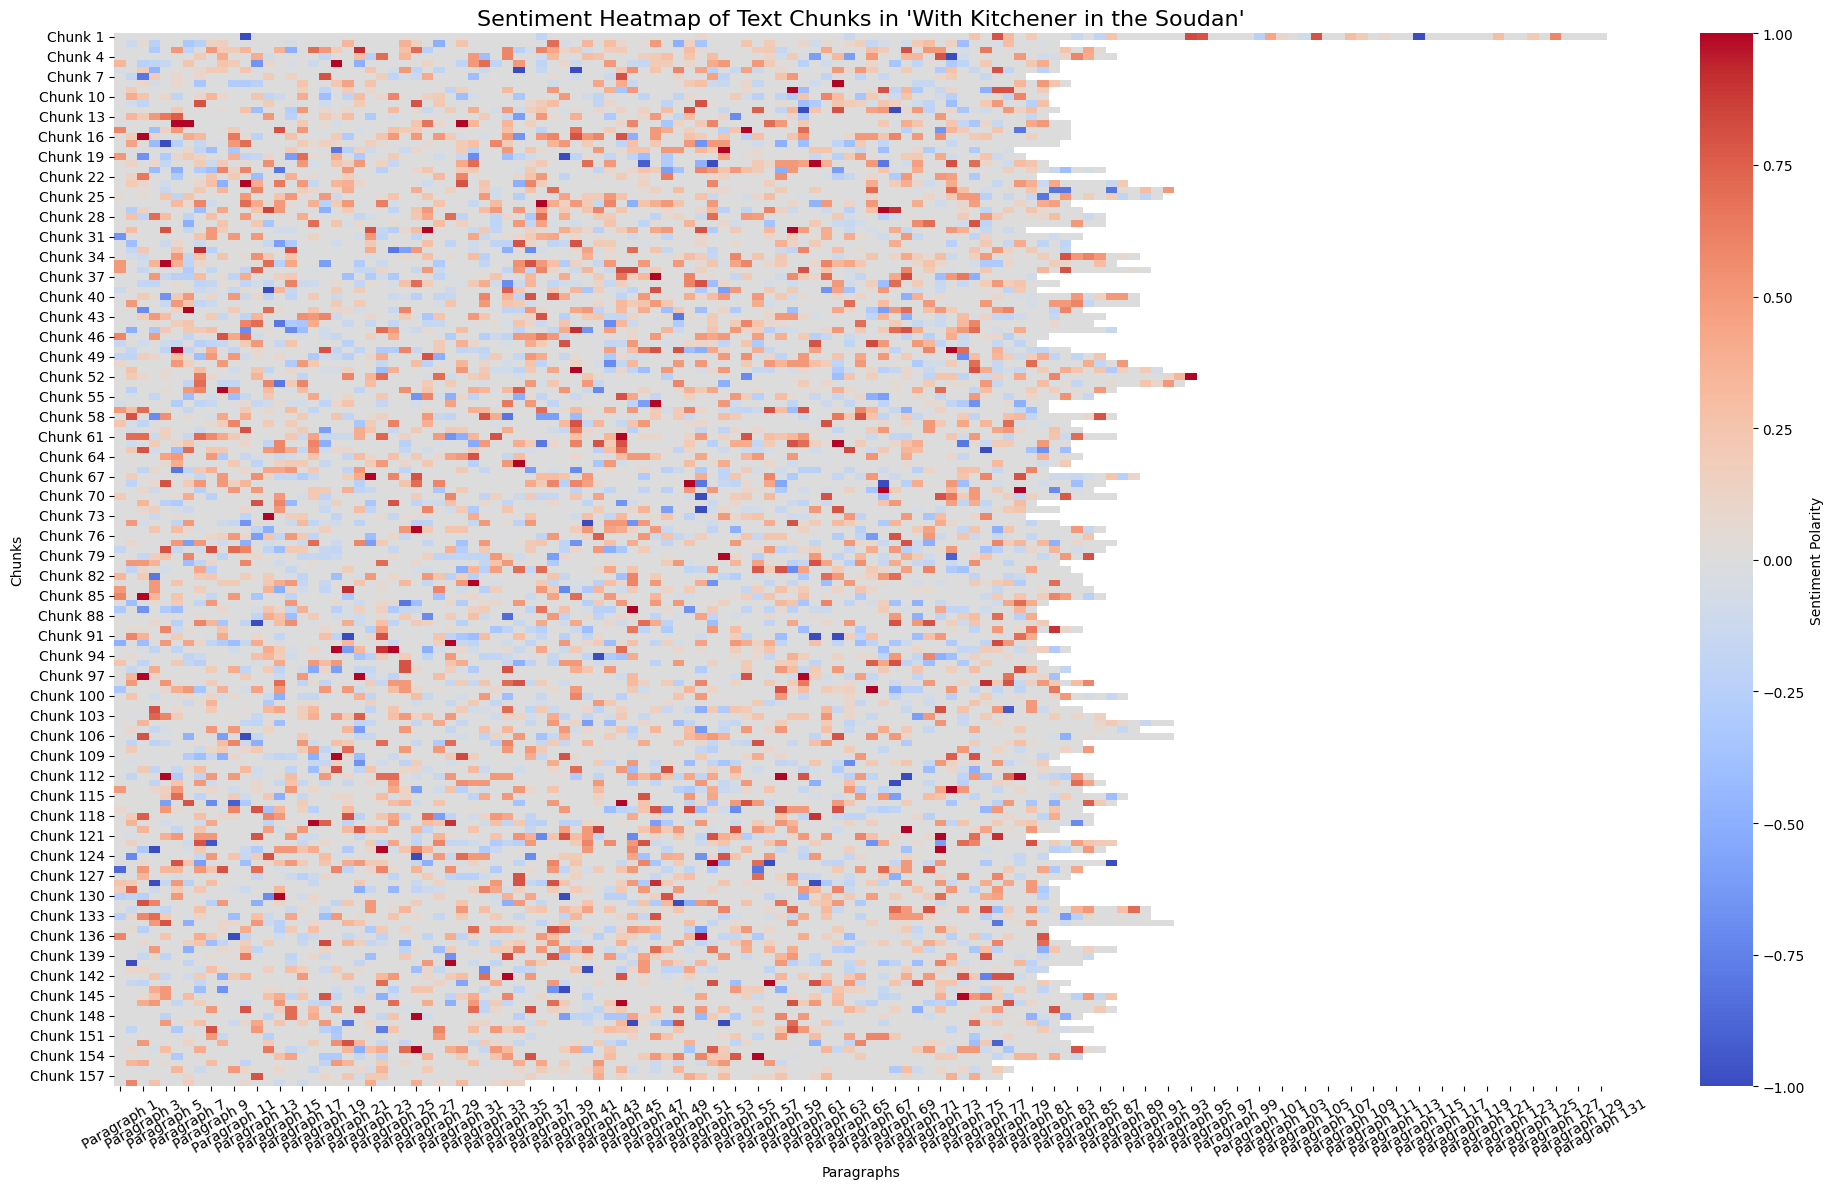

<Figure size 640x480 with 0 Axes>

In [68]:
# Load and Extract Text
with open("kitchener.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file.read(), "html.parser")

# Extract the text from the HTML file
text = soup.get_text(separator="\n")

# Step: Ignore the front matter using the marker
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK WITH KITCHENER IN THE SOUDAN: A STORY OF ATBARA AND OMDURMAN ***"
start_index = text.find(start_marker)
if start_index != -1:
    text = text[start_index + len(start_marker):]  # Trim text after the marker

# Debug: Preview the first 1000 characters of the trimmed text
print("Trimmed text preview:", text[:1000])


# Debug: Preview the first 1000 characters
print("Preview of text:", text[:1000])

# Preprocess Text into Fixed-Size Chunks
def preprocess_text_chunking(text, chunk_size=3000):
    """
    Splits the text into evenly sized chunks based on character count.
    :param text: The entire text as a string.
    :param chunk_size: The number of characters per chunk.
    :return: A list of tuples, where each tuple contains a chunk title and its content.
    """
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    processed_chunks = [(f"Chunk {i+1}", chunk.strip()) for i, chunk in enumerate(chunks)]
    return processed_chunks

# Replace chapters parsing with chunking
chapters = preprocess_text_chunking(text, chunk_size=5000)

# Debug: Print the number of chunks and preview their labels
print(f"Total chunks created: {len(chapters)}")
for i, (title, content) in enumerate(chapters[:5]):  # Preview first 5 chunks
    print(f"{title}: {content[:100]}...")  # Show the first 100 characters of each chunk

# Analyze Sentiment
def analyze_sentiment(chunk_content):
    paragraphs = chunk_content.split("\n\n")  # Split chunk into paragraphs
    scores = []
    for paragraph in paragraphs:
        paragraph = paragraph.lower().strip()
        paragraph = re.sub(r'[^\w\s]', '', paragraph)  # Remove punctuation
        if paragraph:  # Skip empty paragraphs
            sentiment = TextBlob(paragraph).sentiment
            scores.append(sentiment.polarity)
    return scores

# Perform sentiment analysis for each chunk
sentiment_data = []
for chunk_title, chunk_content in chapters:
    scores = analyze_sentiment(chunk_content)
    print(f"Scores for {chunk_title}: {scores[:5]}")  # Debug: print first 5 scores
    sentiment_data.append(scores)

# Check for valid sentiment data
if not sentiment_data:
    raise ValueError("No sentiment data was generated. Check paragraph extraction or content validity.")

# Prepare Data for Heatmap
max_paragraphs = max(len(scores) for scores in sentiment_data)
if max_paragraphs == 0:
    raise ValueError("All chunks appear to be empty. Check input text or preprocessing steps.")

# Create a matrix of sentiment scores
heatmap_data = np.full((len(sentiment_data), max_paragraphs), np.nan)
for i, scores in enumerate(sentiment_data):
    heatmap_data[i, :len(scores)] = scores

# Create a DataFrame for visualization
heatmap_df = pd.DataFrame(
    heatmap_data,
    index=[title for title, _ in chapters],  # Chunk titles as rows
    columns=[f'Paragraph {i+1}' for i in range(max_paragraphs)]  # Paragraph indices as columns
)

# Visualize Heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(
    heatmap_df,
    cmap="coolwarm",
    cbar_kws={'label': 'Sentiment Polarity'},
    annot=False,
    mask=heatmap_df.isnull(),
    vmin=-1, vmax=1  # Ensure consistent scaling
)
plt.title("Sentiment Heatmap of Text Chunks in 'With Kitchener in the Soudan'", fontsize=16)
plt.xlabel("Paragraphs")
plt.ylabel("Chunks")
plt.xticks(rotation=30)
plt.tight_layout()

# Save the heatmap as an image file
plt.savefig("sentiment_heatmap_chunks.png", dpi=300)
plt.show()

#save as PDF
plt.savefig("sentiment_heatmap_chunks.pdf", dpi=300)


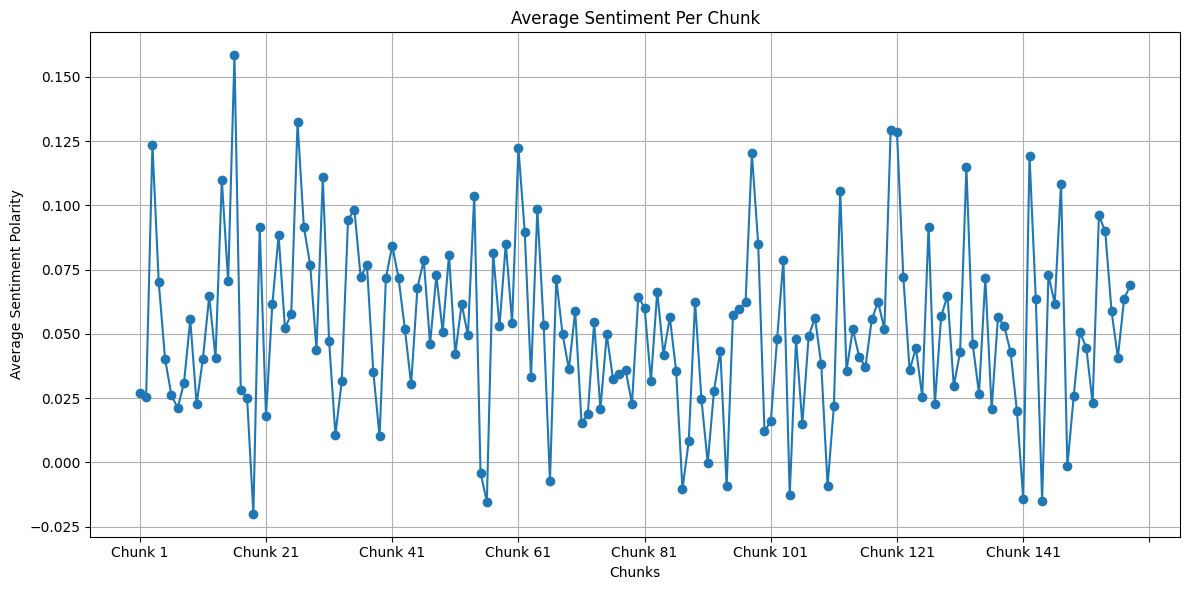

In [69]:
# Compute average sentiment per chunk
avg_sentiment_per_chunk = heatmap_df.mean(axis=1)

# Plot average sentiment per chunk
plt.figure(figsize=(12, 6))
avg_sentiment_per_chunk.plot(kind="line", marker="o", title="Average Sentiment Per Chunk")
plt.xlabel("Chunks")
plt.ylabel("Average Sentiment Polarity")
plt.grid()
plt.tight_layout()
plt.savefig("average_sentiment_per_chunk.png", dpi=300)
plt.show()


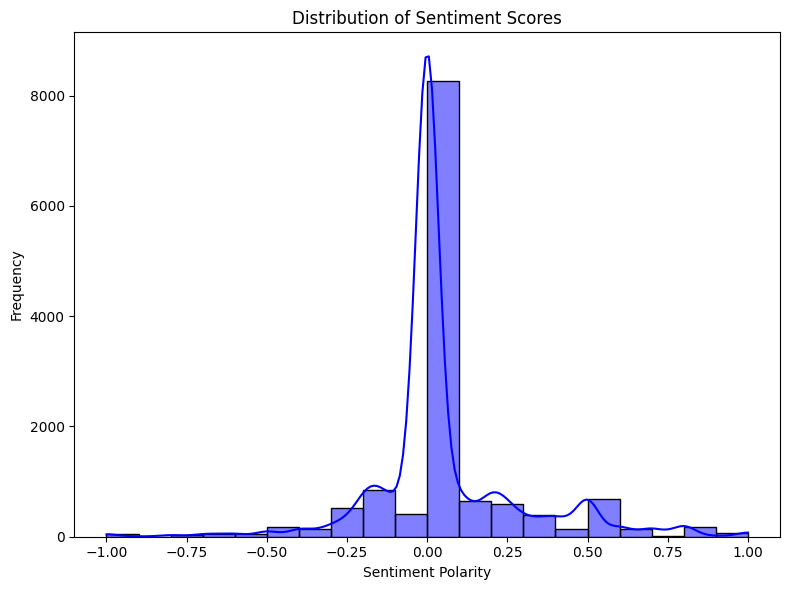

In [70]:
# Flatten sentiment data into a single series
sentiment_scores = heatmap_df.values.flatten()
sentiment_scores = sentiment_scores[~np.isnan(sentiment_scores)]  # Remove NaN values

# Plot the distribution of sentiment scores
plt.figure(figsize=(8, 6))
sns.histplot(sentiment_scores, bins=20, kde=True, color="blue")
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("sentiment_distribution.png", dpi=300)
plt.show()


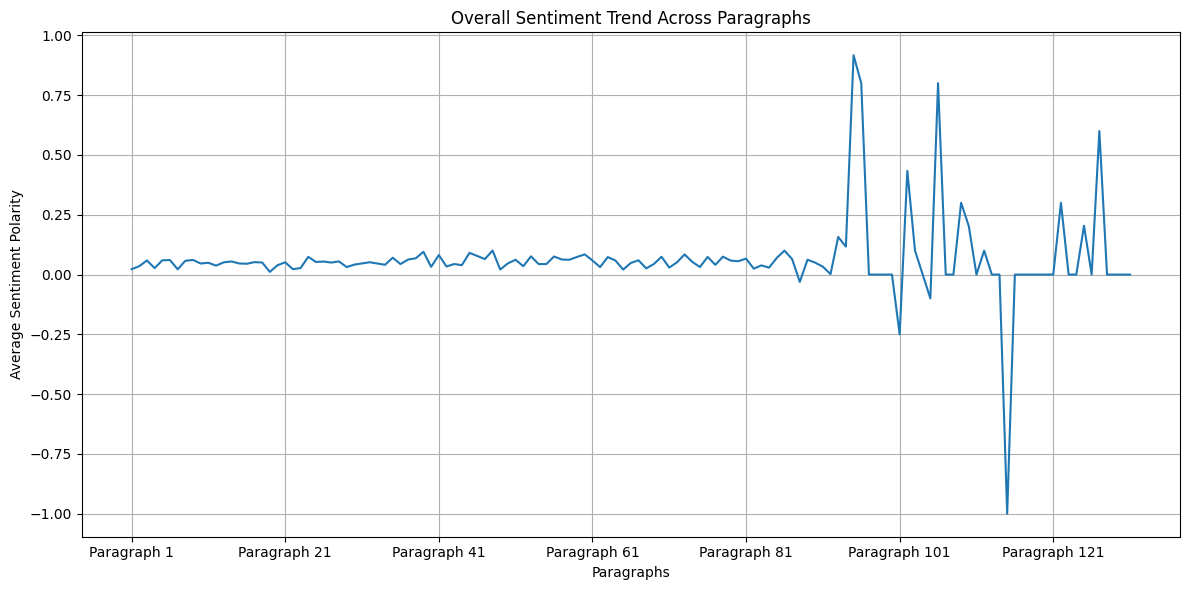

In [71]:
# Compute the overall trend of sentiment across paragraphs
overall_sentiment = heatmap_df.mean(axis=0)

# Plot overall sentiment trend
plt.figure(figsize=(12, 6))
overall_sentiment.plot(kind="line", title="Overall Sentiment Trend Across Paragraphs")
plt.xlabel("Paragraphs")
plt.ylabel("Average Sentiment Polarity")
plt.grid()
plt.tight_layout()
plt.savefig("overall_sentiment_trend.png", dpi=300)
plt.show()


In [72]:
# Find the chunks and paragraphs with the maximum and minimum sentiment scores
max_sentiment = heatmap_df.max().max()
min_sentiment = heatmap_df.min().min()

max_position = np.unravel_index(np.nanargmax(heatmap_data), heatmap_data.shape)
min_position = np.unravel_index(np.nanargmin(heatmap_data), heatmap_data.shape)

print(f"Maximum sentiment: {max_sentiment} at Chunk {max_position[0] + 1}, Paragraph {max_position[1] + 1}")
print(f"Minimum sentiment: {min_sentiment} at Chunk {min_position[0] + 1}, Paragraph {min_position[1] + 1}")


Maximum sentiment: 1.0 at Chunk 5, Paragraph 20
Minimum sentiment: -1.0 at Chunk 1, Paragraph 12


C:\Users\balla\AppData\Local\Temp\ipykernel_36500\161674359.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chunk_groups, x='Chunk', y='Average Sentiment', palette='coolwarm')


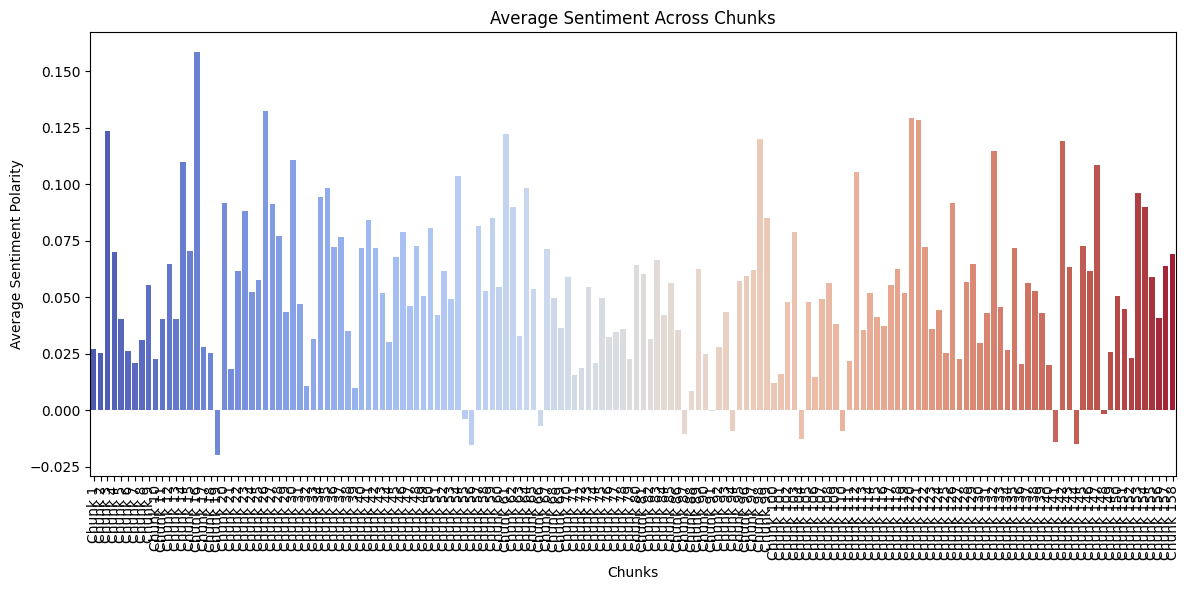

In [73]:
# Compare sentiment scores across chunks
chunk_groups = heatmap_df.mean(axis=1).reset_index()
chunk_groups.columns = ['Chunk', 'Average Sentiment']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=chunk_groups, x='Chunk', y='Average Sentiment', palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Average Sentiment Across Chunks")
plt.xlabel("Chunks")
plt.ylabel("Average Sentiment Polarity")
plt.tight_layout()
plt.savefig("chunk_comparison.png", dpi=300)
plt.show()


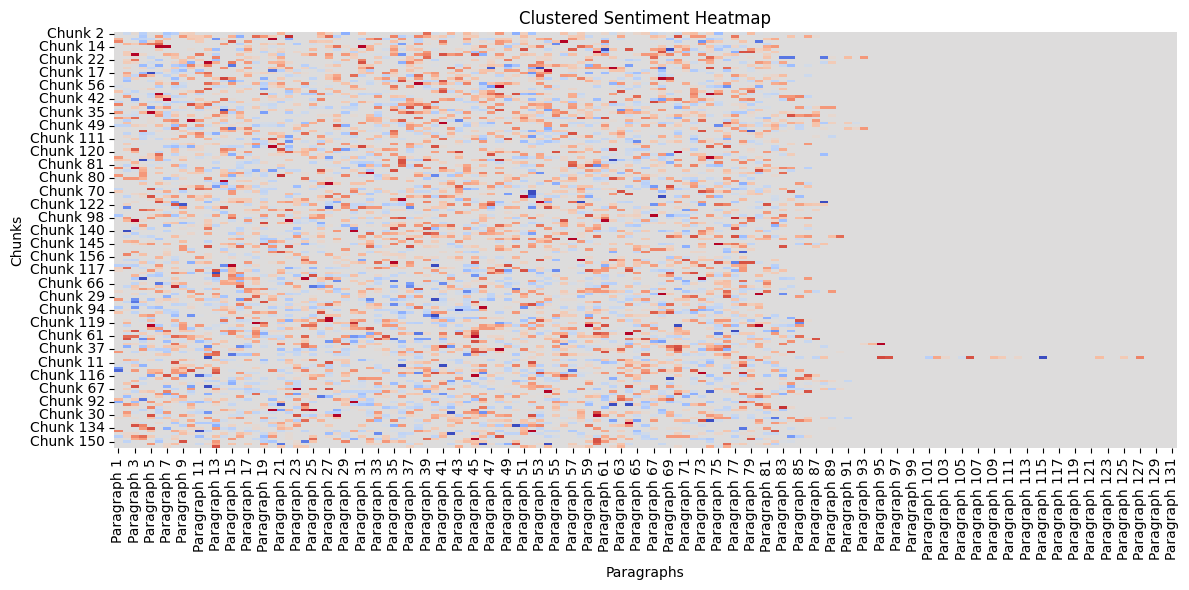

In [74]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_data = pca.fit_transform(data_for_clustering.drop(columns='Cluster'))
kmeans = KMeans(n_clusters=3, random_state=42).fit(reduced_data)

# Replace NaN with 0 for clustering
data_for_clustering = heatmap_df.fillna(0)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(data_for_clustering)

# Add the cluster labels to the DataFrame
data_for_clustering['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster labels
sorted_data = data_for_clustering.sort_values('Cluster')

# Visualize the sorted heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_data.drop(columns='Cluster'), cmap="coolwarm", cbar=False)
plt.title("Clustered Sentiment Heatmap")
plt.xlabel("Paragraphs")
plt.ylabel("Chunks")
plt.tight_layout()
plt.savefig("clustered_heatmap.png", dpi=300)
plt.show()



In [75]:
for cluster_label in sorted(data_for_clustering['Cluster'].unique()):
    cluster_chunks = data_for_clustering[data_for_clustering['Cluster'] == cluster_label]
    print(f"Chunks in Cluster {cluster_label}:")
    print(cluster_chunks.index.tolist())


Chunks in Cluster 0:
['Chunk 2', 'Chunk 3', 'Chunk 5', 'Chunk 9', 'Chunk 12', 'Chunk 13', 'Chunk 14', 'Chunk 15', 'Chunk 16', 'Chunk 17', 'Chunk 18', 'Chunk 20', 'Chunk 21', 'Chunk 22', 'Chunk 23', 'Chunk 24', 'Chunk 26', 'Chunk 27', 'Chunk 28', 'Chunk 32', 'Chunk 34', 'Chunk 35', 'Chunk 39', 'Chunk 40', 'Chunk 41', 'Chunk 42', 'Chunk 46', 'Chunk 47', 'Chunk 48', 'Chunk 49', 'Chunk 51', 'Chunk 53', 'Chunk 54', 'Chunk 56', 'Chunk 57', 'Chunk 59', 'Chunk 60', 'Chunk 65', 'Chunk 68', 'Chunk 70', 'Chunk 72', 'Chunk 73', 'Chunk 75', 'Chunk 76', 'Chunk 78', 'Chunk 80', 'Chunk 81', 'Chunk 83', 'Chunk 84', 'Chunk 85', 'Chunk 96', 'Chunk 97', 'Chunk 98', 'Chunk 99', 'Chunk 101', 'Chunk 102', 'Chunk 103', 'Chunk 105', 'Chunk 107', 'Chunk 108', 'Chunk 109', 'Chunk 110', 'Chunk 111', 'Chunk 114', 'Chunk 115', 'Chunk 118', 'Chunk 120', 'Chunk 122', 'Chunk 124', 'Chunk 125', 'Chunk 127', 'Chunk 128', 'Chunk 129', 'Chunk 130', 'Chunk 132', 'Chunk 135', 'Chunk 137', 'Chunk 138', 'Chunk 139', 'Chunk 14

In [76]:
max_chunk = heatmap_df.max().idxmax()
min_chunk = heatmap_df.min().idxmin()
print(f"Most Positive Chunk: {max_chunk}")
print(f"Most Negative Chunk: {min_chunk}")


Most Positive Chunk: Paragraph 3
Most Negative Chunk: Paragraph 2


In [77]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')


def preprocess_text(text):
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    # Tokenize words
    words = word_tokenize(text.lower())
    # Remove stop words and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return processed_words


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Combine chunks into a list of documents
chunk_texts = [" ".join(preprocess_text(content)) for _, content in chapters]

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(chunk_texts)

# Apply LDA
n_topics = 3  # Adjust number of themes as needed
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(dtm)

# Extract and display themes
for index, topic in enumerate(lda.components_):
    print(f"Theme {index + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\balla/nltk_data'
    - 'c:\\Users\\balla\\Documents\\csis-dspython\\wm-nlp-07\\.venv\\nltk_data'
    - 'c:\\Users\\balla\\Documents\\csis-dspython\\wm-nlp-07\\.venv\\share\\nltk_data'
    - 'c:\\Users\\balla\\Documents\\csis-dspython\\wm-nlp-07\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\balla\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [81]:
# Map cluster labels to chunks
cluster_texts = {}
for cluster_label in sorted(data_for_clustering['Cluster'].unique()):
    cluster_chunks = data_for_clustering[data_for_clustering['Cluster'] == cluster_label]
    cluster_texts[cluster_label] = " ".join(
        chunk_texts[i] for i in cluster_chunks.index
    )

# Apply LDA to each cluster
for cluster_label, text in cluster_texts.items():
    print(f"Cluster {cluster_label}:")
    dtm = vectorizer.transform([text])  # Transform text into document-term matrix
    topics = lda.transform(dtm)  # Fit the LDA model
    print(f"Dominant Theme Words:")
    print([vectorizer.get_feature_names_out()[i] for i in lda.components_[0].argsort()[-10:]])


NameError: name 'chunk_texts' is not defined

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster_label, text in cluster_texts.items():
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_label}")
    plt.show()


In [86]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation

# Combine chunks into a list of documents
chunk_texts = [" ".join(preprocess_text(content)) for _, content in chapters]

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(chunk_texts)

# Apply LDA
n_topics = 3  # Adjust number of themes as needed
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(dtm)

# Example for a single theme
theme_words = lda.components_[0]
top_indices = theme_words.argsort()[-10:]
top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]
top_scores = theme_words[top_indices]

# Plot
plt.barh(top_words, top_scores, color="blue")
plt.title("Top Words in Theme")
plt.xlabel("Importance")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\balla/nltk_data'
    - 'c:\\Users\\balla\\Documents\\csis-dspython\\wm-nlp-07\\.venv\\nltk_data'
    - 'c:\\Users\\balla\\Documents\\csis-dspython\\wm-nlp-07\\.venv\\share\\nltk_data'
    - 'c:\\Users\\balla\\Documents\\csis-dspython\\wm-nlp-07\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\balla\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
